# Notebook to introduce random forest analyses and the concepts of bagging. 

Edited and Updated by Danny Lumian

Thanks to Micheal Dyer

# Objectives:

    -Compare and contrast decision trees with random forest

    -Understand how bagging differentiates the two

    -Use partial dependence plots to visualize effects


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style("white")

#-----------------------------------------------------
import pandas as pd
import numpy as np

#----Model selection--------------------------------
from sklearn.model_selection import train_test_split
from sklearn import datasets
#----------------------------------------------------

#----Models--------------------------------
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

#----Tree visualization--------------------------------
from sklearn.tree import export_graphviz
from IPython.display import Image

np.random.seed(0)

In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.size'           : 20.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'medium',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'large',
})

In [3]:
##Split data set in train 80% and test 20%
boston = datasets.load_boston()
X, y = boston.data[:,0:3], boston.target  

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((404, 3), (404,), (102, 3), (102,))

In [4]:
# What does our target look like? (median house values in 1000s of dollars)
y[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

crim  
per capita crime rate by town.

zn  
proportion of residential land zoned for lots over 25,000 sq.ft.

indus  
proportion of non-retail business acres per town.

Target:
medv  
median value of owner-occupied homes in \$1000s.

In [5]:
num_estimator_list = [1,2,5,10,20,40,100,500,1000]
train_errors = []
test_errors = []

for num_trees in num_estimator_list:
    
    # Make a list of decision trees
    trees = [DecisionTreeRegressor(max_depth = 2, random_state=1) for tree in range(num_trees)]
    
    # Fit each tree, underscore is a throwaway to suppress output [None, None, etc.] in jupyter notebook 
    _ = [tree.fit(X_train, y_train) for tree in trees]
    
    y_preds_train  = [tree.predict(X_train) for tree in trees]
    y_preds_test  = [tree.predict(X_test) for tree in trees]
    
    # Average the predicts and calculate the mean squared error for test and train
    train_errors.append(mean_squared_error(np.array(y_preds_train).mean(axis=0), y_train))
    test_errors.append(mean_squared_error(np.array(y_preds_test).mean(axis=0), y_test))


# Before plotting: 

    -What do you expect to see for N-estimators by MSE?
    
    -Check your variables to get an idea?
    
    -Is our model deterministic?
    

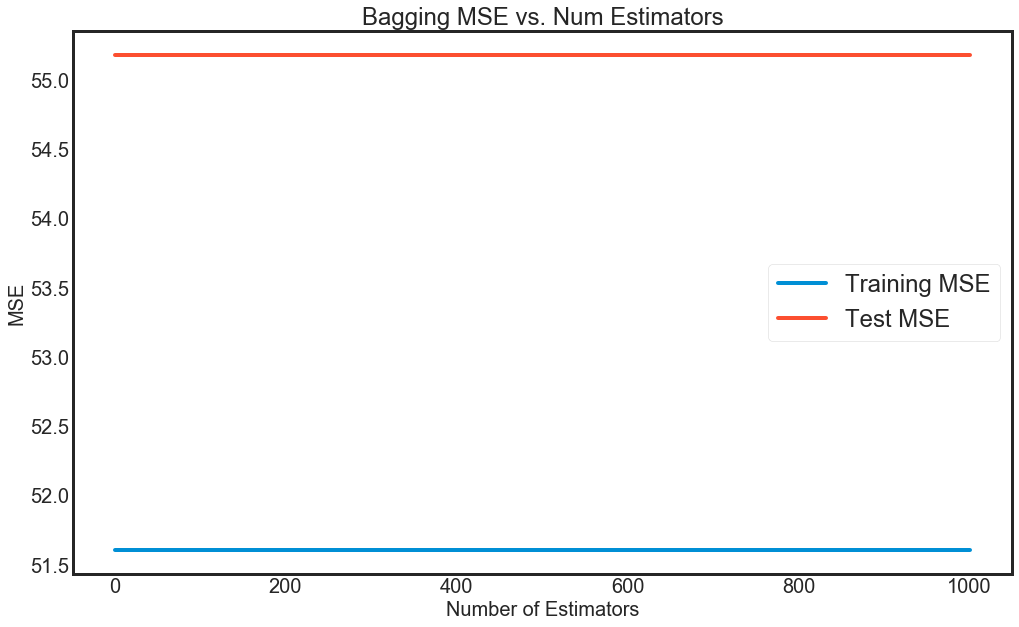

In [6]:
plt.figure(figsize=(15,10))
plt.plot(num_estimator_list, train_errors, label='Training MSE')
plt.plot(num_estimator_list, test_errors, label='Test MSE')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
# plt.xscale('log')
plt.title('Bagging MSE vs. Num Estimators')
plt.legend()

In [7]:
def show_tree(tree):
    # export to graph description language
    export_graphviz(tree, "tree.dot")
    
    # Execute bash command to convert from .dot format to .png format
    !dot -Tpng tree.dot -o tree.png
    
    # iPython shows the image!
    return Image("tree.png")


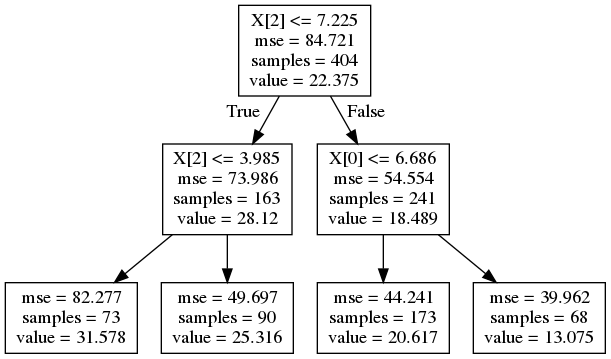

In [8]:
show_tree(trees[0])

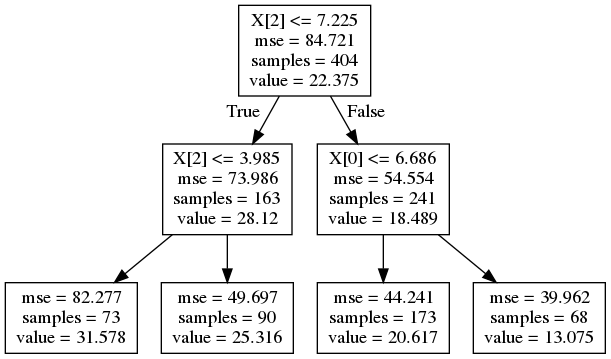

In [9]:
show_tree(trees[5])

### These are the same tree!

### Let's see how bagging works!

In [10]:
# Intialize Train and test lists
train_errors_bagging = []
test_errors_bagging = []

# Make a base tree, normally we would make these bushier but let's just use two so they're easier to visualize

regtree = DecisionTreeRegressor(max_depth = 2)

num_estimator_list = [1,2,5,10,20,40,100,500,1000]

for num_est in num_estimator_list:
    
    bag = BaggingRegressor(base_estimator=regtree, n_estimators=num_est, n_jobs=-1)
    bag.fit(X_train, y_train)
    y_pred_test =  bag.predict(X_test)
    y_pred_train =  bag.predict(X_train)
    
    train_errors_bagging.append(mean_squared_error(y_pred_train, y_train)) 
    test_errors_bagging.append(mean_squared_error(y_pred_test, y_test))

# Before plotting: 

    -What do you expect to see for N-estimators by MSE?
    
    -Check your variables (e.g., compare test_errors with test_errors_bagging) to get an idea?
    
    -Is our model deterministic?
    

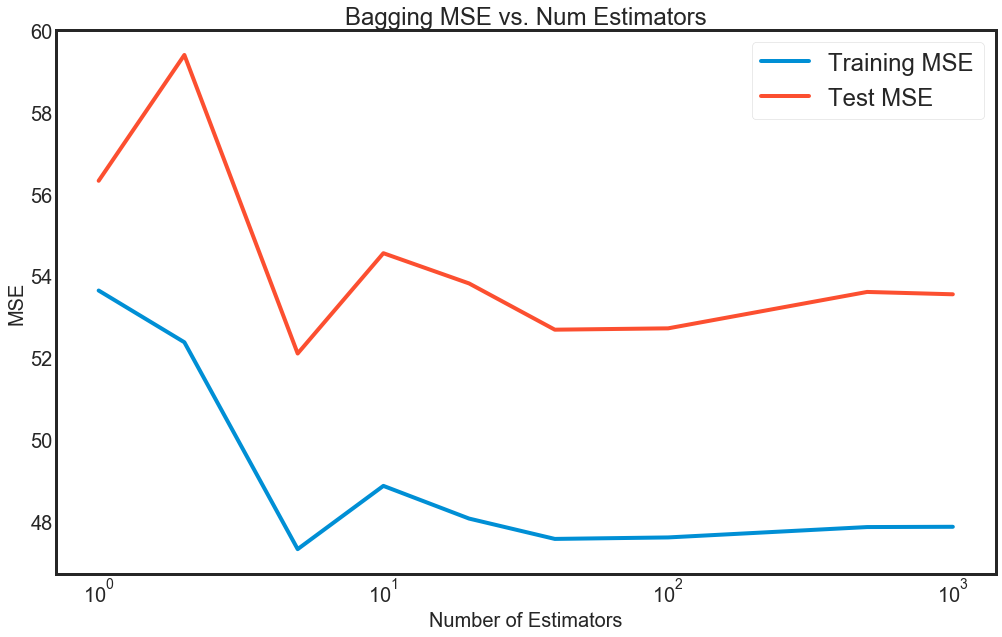

In [11]:
plt.figure(figsize=(15,10))
plt.plot(num_estimator_list, train_errors_bagging, label='Training MSE')
plt.plot(num_estimator_list, test_errors_bagging, label='Test MSE')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.xscale('log')

plt.title('Bagging MSE vs. Num Estimators')
plt.legend()

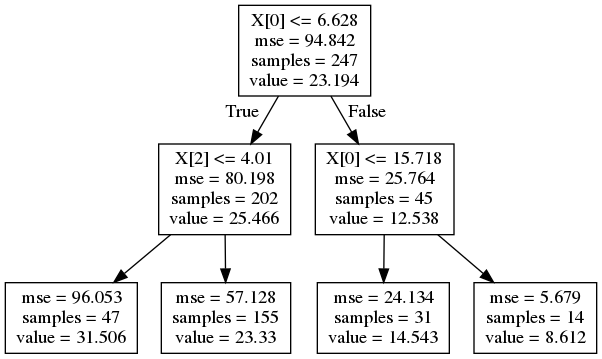

In [12]:
show_tree(bag.estimators_[0])

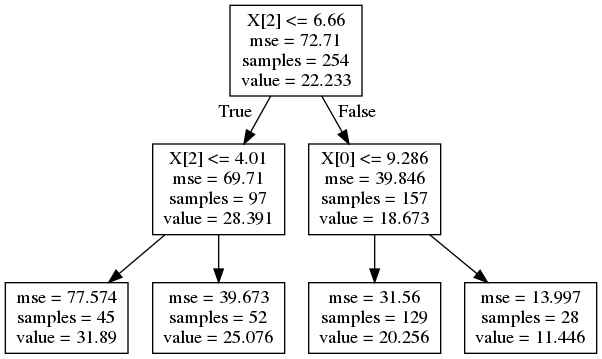

In [13]:
show_tree(bag.estimators_[5])

### A random forest:

In [14]:
train_errors_rf = []
test_errors_rf = []

for num_est in num_estimator_list:
    rf = RandomForestRegressor(n_estimators = num_est, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_test =  rf.predict(X_test)
    y_pred_train =  rf.predict(X_train)
    
    train_errors_rf.append(mean_squared_error(y_pred_train, y_train)) 
    test_errors_rf.append(mean_squared_error(y_pred_test, y_test))

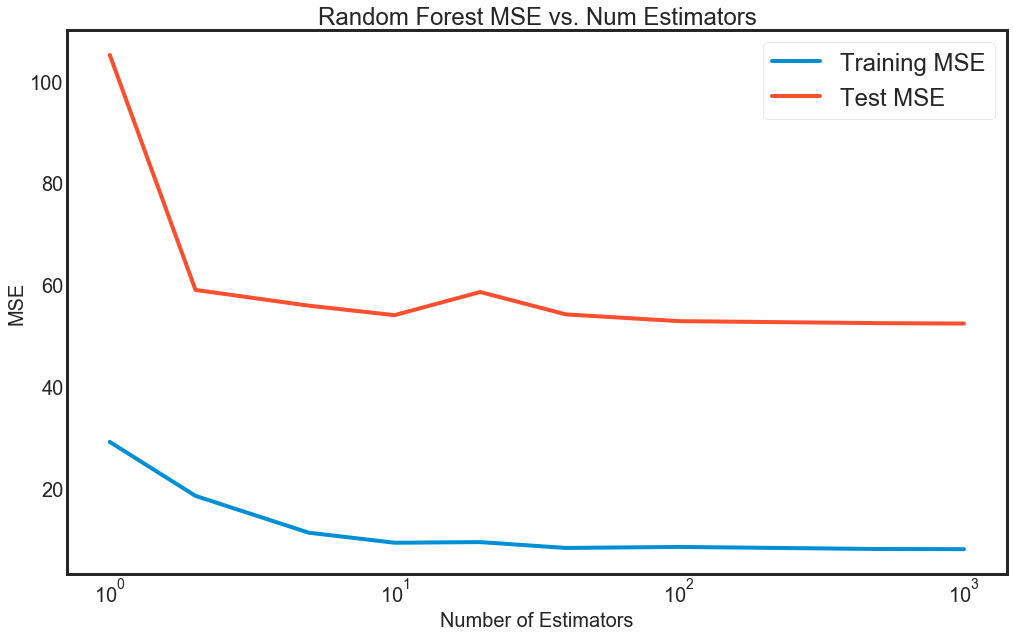

In [15]:
plt.figure(figsize=(15,10))
plt.plot(num_estimator_list, train_errors_rf, label='Training MSE')
plt.plot(num_estimator_list, test_errors_rf, label='Test MSE')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.xscale('log')
plt.title('Random Forest MSE vs. Num Estimators')
plt.legend()

## Instead of a train-test split, use OOB score instead

/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn

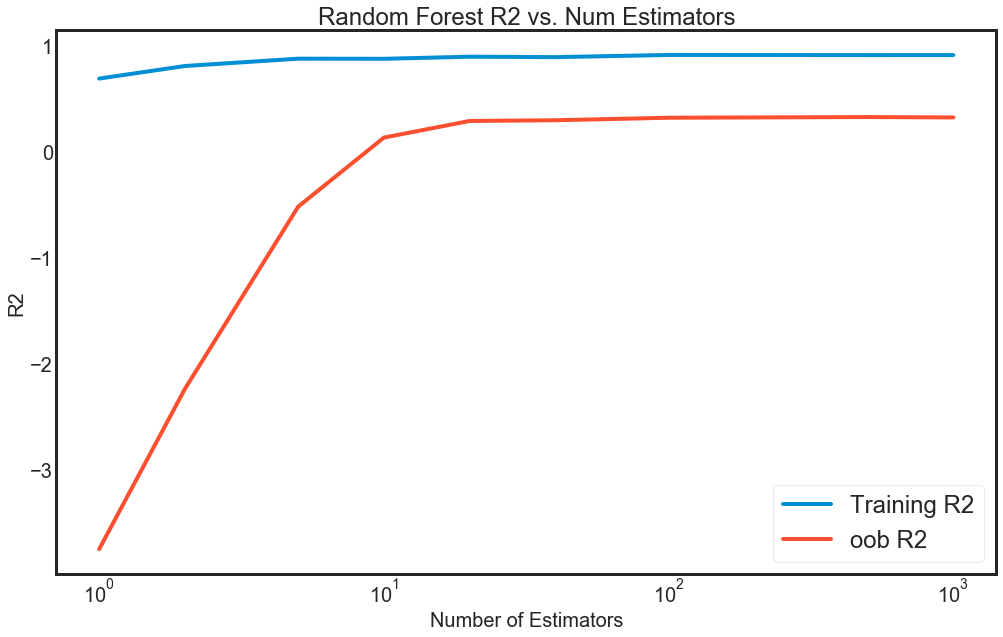

In [16]:
from sklearn.metrics import r2_score
train_r2_rf = []
oob_r2_rf = []

for num_est in num_estimator_list:
    rf = RandomForestRegressor(n_estimators = num_est, oob_score=True, n_jobs=-1)
    rf.fit(X, y)
    #y_pred_test =  rf.predict(X_test)
    y_pred =  rf.predict(X)
    
    train_r2_rf.append(r2_score(y, y_pred)) 
    oob_r2_rf.append(rf.oob_score_)

    
plt.figure(figsize=(15,10))
plt.plot(num_estimator_list, train_r2_rf, label='Training R2')
plt.plot(num_estimator_list, oob_r2_rf, label='oob R2')
plt.xlabel('Number of Estimators')
plt.ylabel('R2')
plt.xscale('log')
plt.title('Random Forest R2 vs. Num Estimators')
plt.legend()    

### How can we interpret our models?
First, let's look at feature importance:

In [17]:
# Make a model
rf = RandomForestRegressor(n_estimators = 30, n_jobs=-1)
rf.fit(X_train, y_train)

feature_names = boston.feature_names[0:3]

Text(0.5, 0, 'Features')

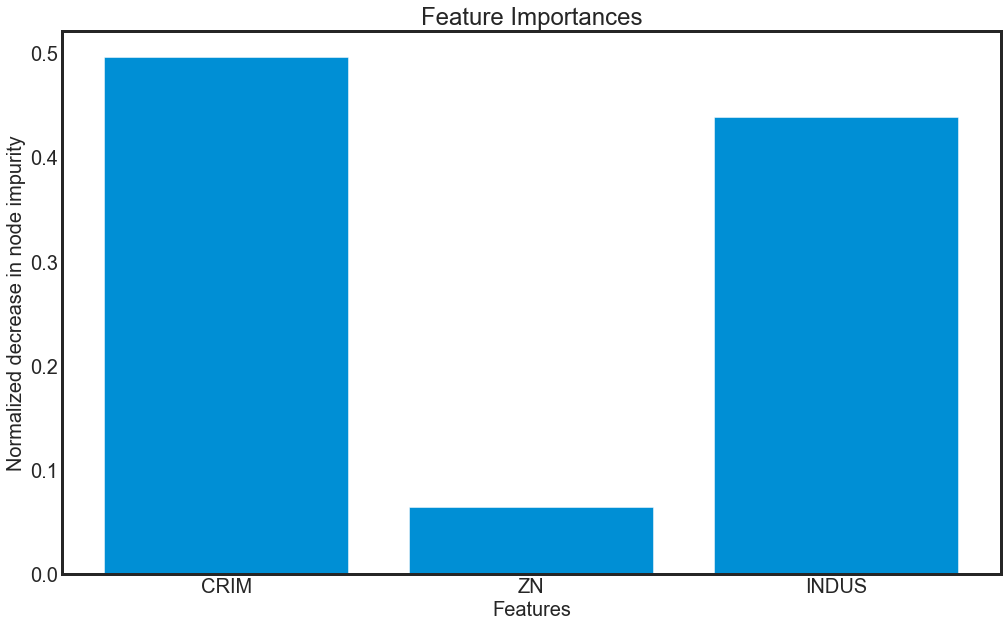

In [18]:
plt.figure(figsize = (15,10))
plt.bar(feature_names, rf.feature_importances_)
plt.title('Feature Importances')
plt.ylabel("Normalized decrease in node impurity")
plt.xlabel("Features")

### That's nice, is there a way we can visualize how different values of a feature affect the prediction?
We can use Partial Dependence Plots!
Unfortunately the Sklearn implementation of this only works for Gradient Boosted Models.  Here's what that looks like.

crim  
per capita crime rate by town.

zn  
proportion of residential land zoned for lots over 25,000 sq.ft.

indus  
proportion of non-retail business acres per town.

Target:
medv  
median value of owner-occupied homes in \$1000s.

/home/frank/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)


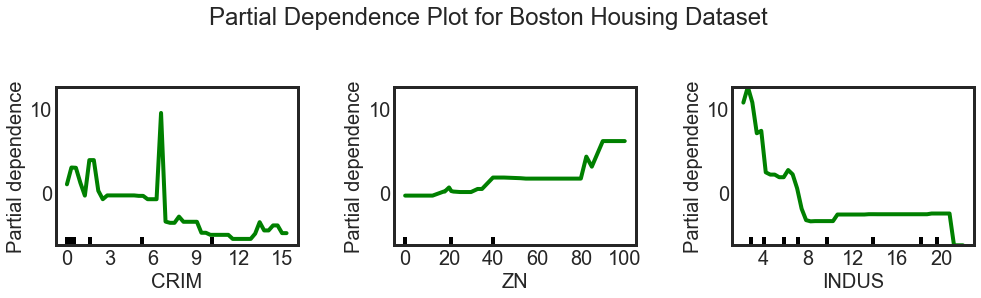

In [19]:
# Sklearn example (only for gradient boosting as of 0.20.0)

from sklearn.ensemble import GradientBoostingRegressor
## plot_partial_dependence only works for gradient boosting models; hopefully will be updated soon
gb = GradientBoostingRegressor(n_estimators = 100)
gb.fit(X_train, y_train)


fig, axs = plot_partial_dependence(gb, X_train, [0,1,2],
                                       feature_names=boston.feature_names[0:3],
                                       n_jobs=-1, grid_resolution=50)
fig.suptitle('Partial Dependence Plot for Boston Housing Dataset')
fig.set_figwidth(15)

How to interpret y - axis: 
“The partial dependence curve at a certain feature value represents the average prediction when we force all data points to take on that feature value.”